### Objective

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type.

### Suggestions

- You could build a machine learning model that predicts how much someone will spend based on demographics and offer type.
- Or you could build a model that predicts whether or not someone will respond to an offer.
- Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Starbucks

The project uses the [CRISP-DM](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining) process and is divided into the following parts:

## 1. Business understanding

Some questions we might want to answer are:

- What is the expected value that each customer will spend?
- What are the characteristics and behaviors that predict how much a customer will spend?
- Which offer type should be send depending on the predicted value the customer will spend?
- Who are the customers that have a high probability of completing an offer?
- Which channels are better for each demographic?
- What was the return on investment (ROI) of the current experiment and how does it compare to the proposed solution?

Since we have access to the experiment data containing only the treatment, we will take a simpler approach to solve this problem, which is ______.

But if we consider a scenario where we work at Starbucks and have access to data from other customers, a great approach would be to use [uplift models](https://www.youtube.com/watch?v=2J9j7peWQgI&t=1359s), from the [causalml library](https://github.com/uber/causalml). With that, we could use:
- [S, T or X Meta-learners](https://causalml.readthedocs.io/en/latest/methodology.html#meta-learner-algorithms). Provided that this experiment was an A/B test and had a control group. [[1]](https://www.pnas.org/content/pnas/116/10/4156.full.pdf)
- [R Meta-learner](https://causalml.readthedocs.io/en/latest/methodology.html#r-learner). Provided that we had a pool of customers that did not receive any offer, to be able to build a balanced control and compare it against the treatment. [[2]](https://arxiv.org/pdf/1712.04912.pdf)

[[1]](https://www.pnas.org/content/pnas/116/10/4156.full.pdf) Künzel, Sören R., et al. "Metalearners for estimating heterogeneous treatment effects using machine learning." Proceedings of the national academy of sciences 116.10 (2019): 4156-4165.

[[2]](https://arxiv.org/pdf/1712.04912.pdf) Nie, Xinkun, and Stefan Wager. "Quasi-oracle estimation of heterogeneous treatment effects." arXiv preprint arXiv:1712.04912 (2017).

## 2. Data understanding

### 2.1. Importing libraries

In [1]:
import numpy as np
import pandas as pd
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use("./style/minimal.mplstyle")

import warnings
warnings.filterwarnings("ignore")

%config InlineBackend.figure_format="retina"

### 2.2. Loading data

In [2]:
portfolio = pd.read_json("data/portfolio.json", orient="records", lines=True)
profile = pd.read_json("data/profile.json", orient="records", lines=True)
transcript = pd.read_json("data/transcript.json", orient="records", lines=True)

In [3]:
print("Portfolio shape: ", portfolio.shape)
print("Profile shape:   ", profile.shape)
print("Transcript shape:", transcript.shape)

Portfolio shape:  (10, 6)
Profile shape:    (17000, 5)
Transcript shape: (306534, 4)


In [4]:
portfolio.sort_values(by=["offer_type", "difficulty", "duration"])

,reward,channels,difficulty,duration,offer_type,id
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed


In [5]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [6]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [44]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
year                   0
month                  0
cohort                 0
dtype: int64

In [7]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [8]:
time_min = transcript.describe().loc["min", :]
time_max = transcript.describe().loc["max", :]

print(f"Transcript has {int(round((time_max - time_min)/24))} days of data")

Transcript has 30 days of data


### 2.3. Adjusting data types

In [9]:
profile["became_member_on"] = pd.to_datetime(profile["became_member_on"].astype(str), format="%Y%m%d")

In [10]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [11]:
profile["year"] = profile["became_member_on"].dt.year
profile["month"] = profile["became_member_on"].dt.month
profile["cohort"] = profile["became_member_on"].dt.strftime('%Y-%m').astype(str)

In [12]:
profile.head()

,gender,age,id,became_member_on,income,year,month,cohort
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017,2,2017-02
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,2017-07
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018,7,2018-07
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,2017-05
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017,8,2017-08


### 2.4. Dividing the data

In [13]:
# Showing all event types
transcript["event"].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [ ]:
# Showing the first line of each event type
transcript.iloc[[0, 12650, 12654, 12658], :]

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0


In [200]:
transcript["offer_id"] = transcript["value"].apply(lambda x: x.get("offer id"))
transcript["amount"] = transcript["value"].apply(lambda x: x.get("amount"))

### 2.5. Exploratory data analysis

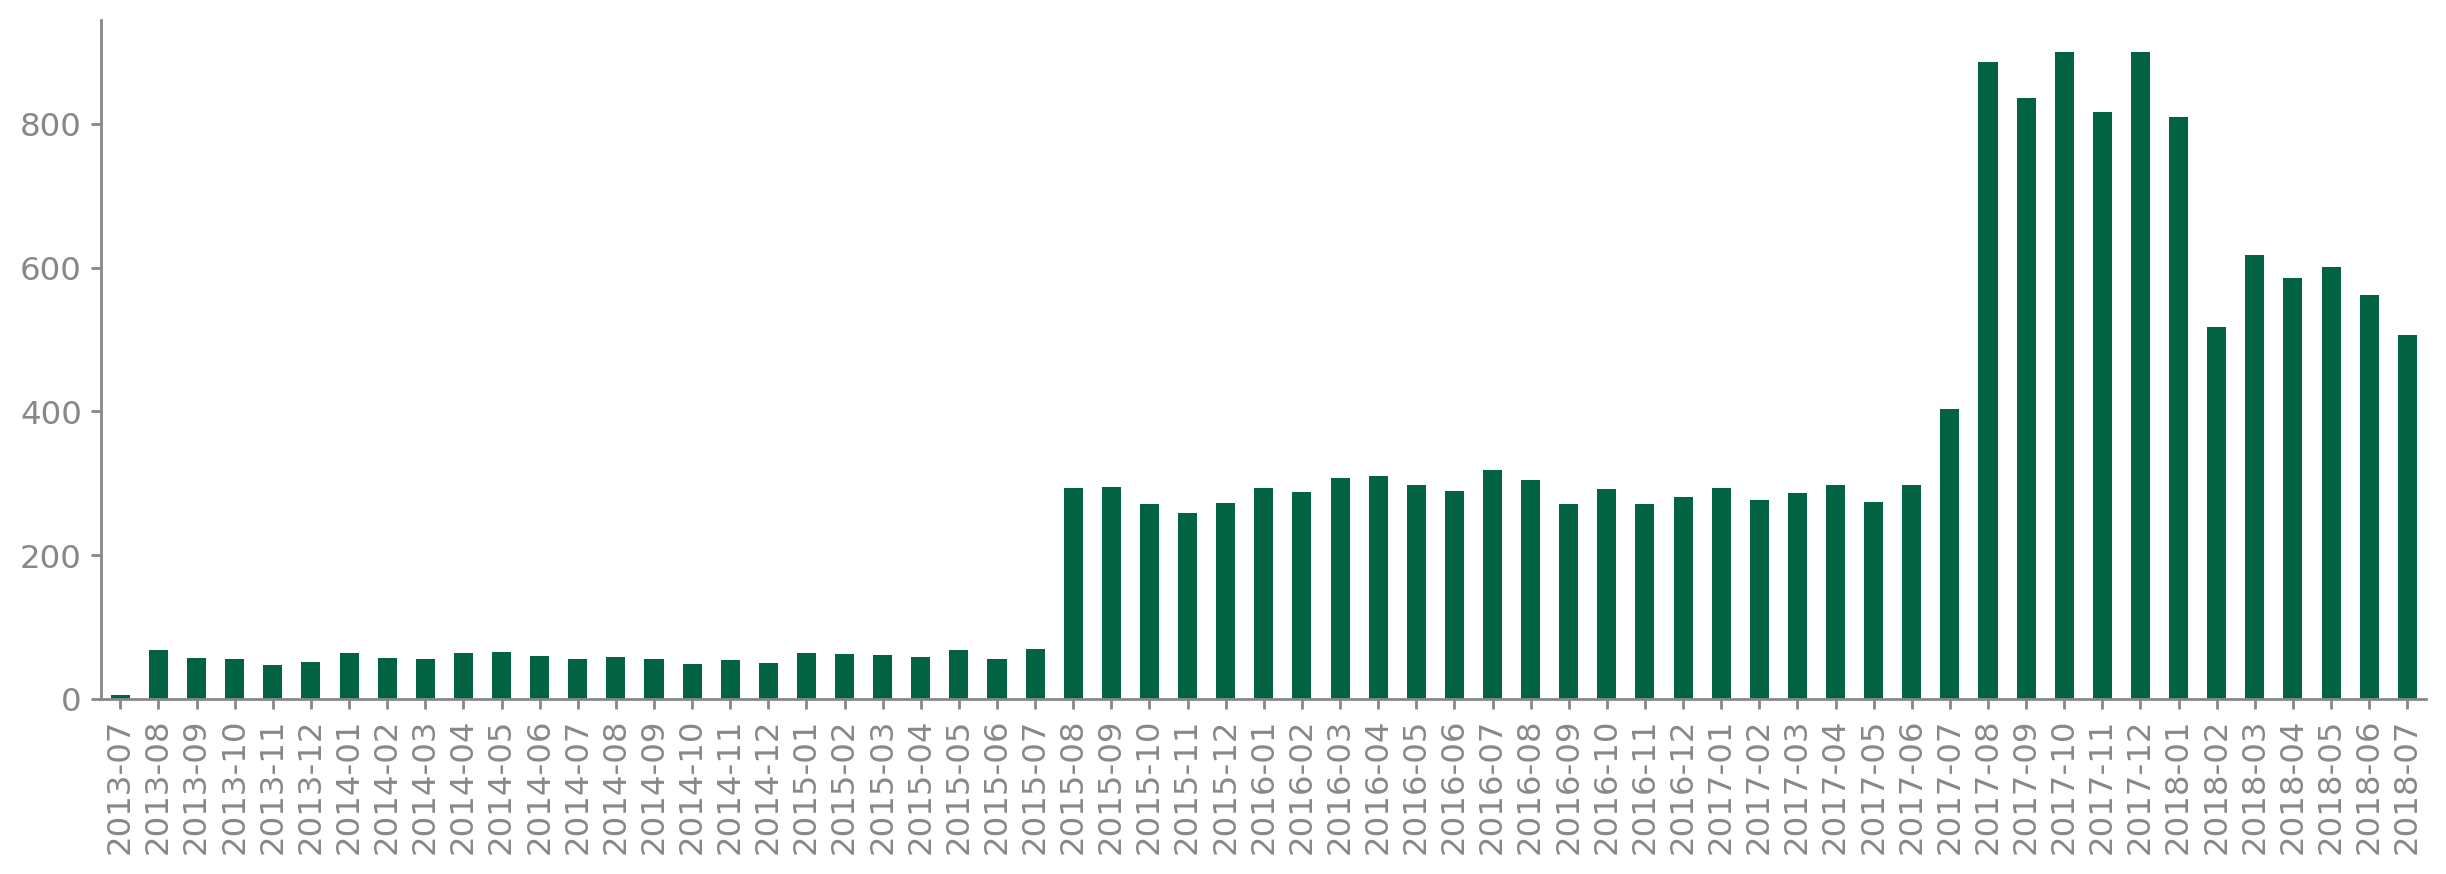

In [19]:
plt.figure(figsize=(15, 4.5))
profile["cohort"].value_counts().sort_index().plot.bar();

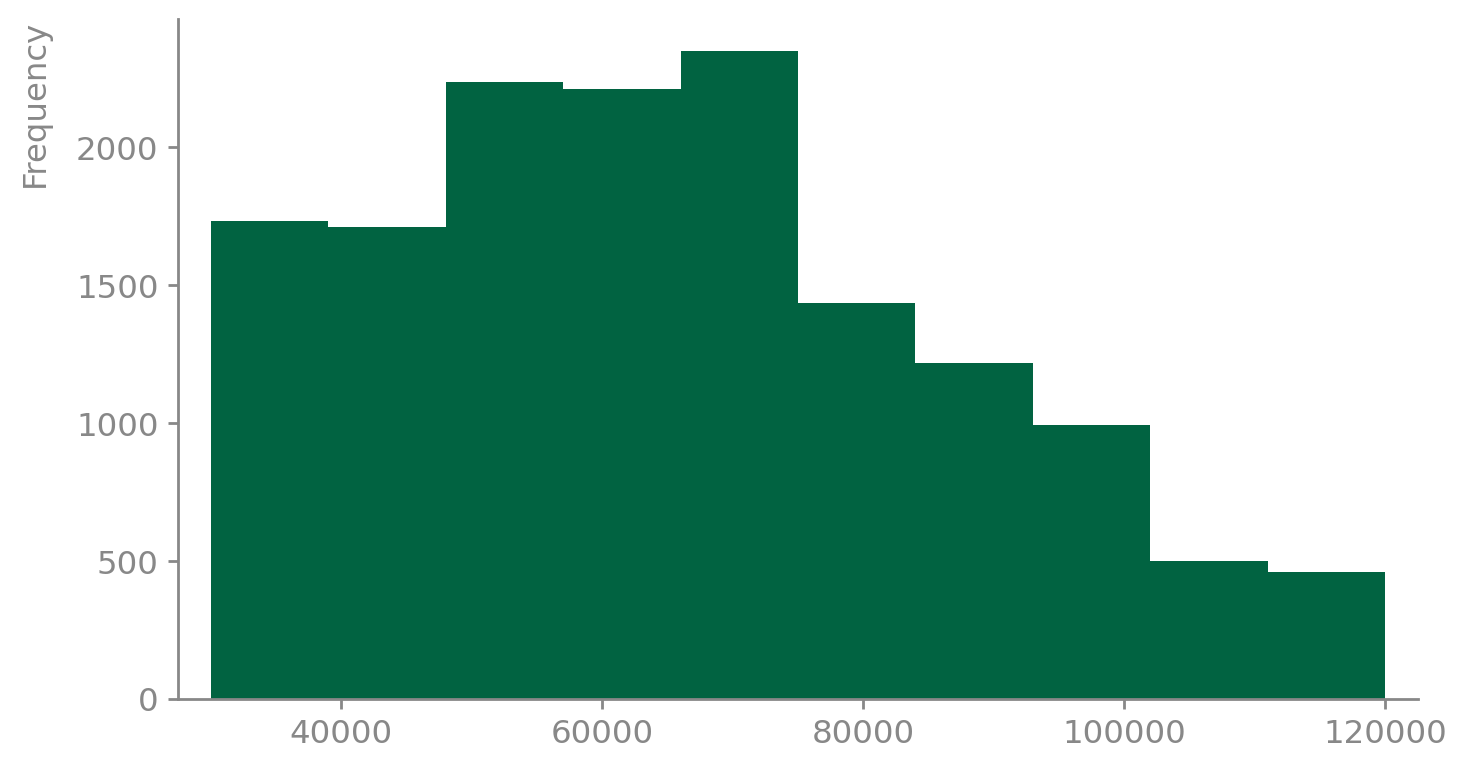

In [20]:
plt.figure(figsize=(8, 4.5))
profile["income"].plot.hist();

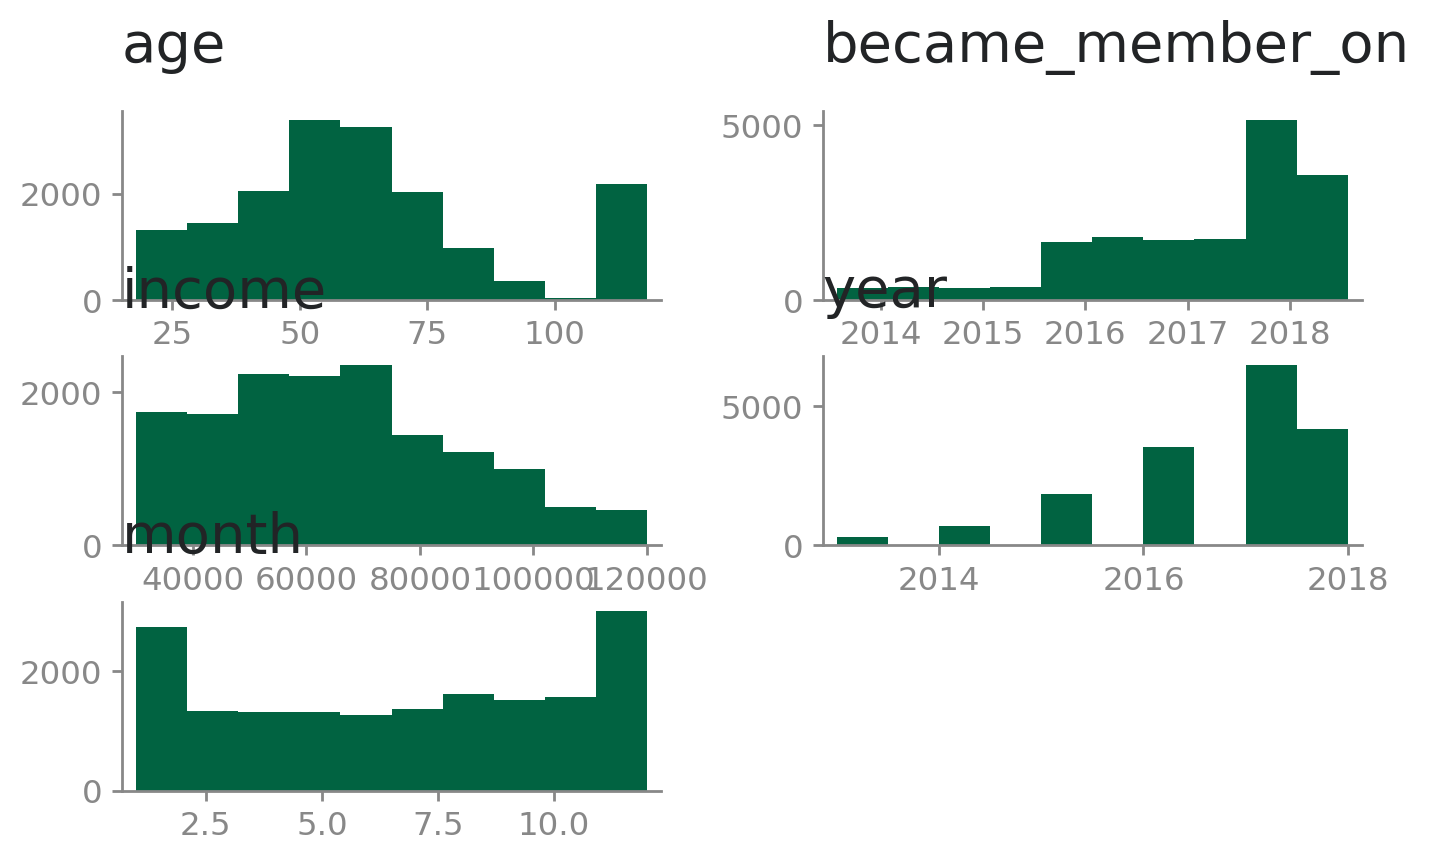

In [21]:
profile.hist();

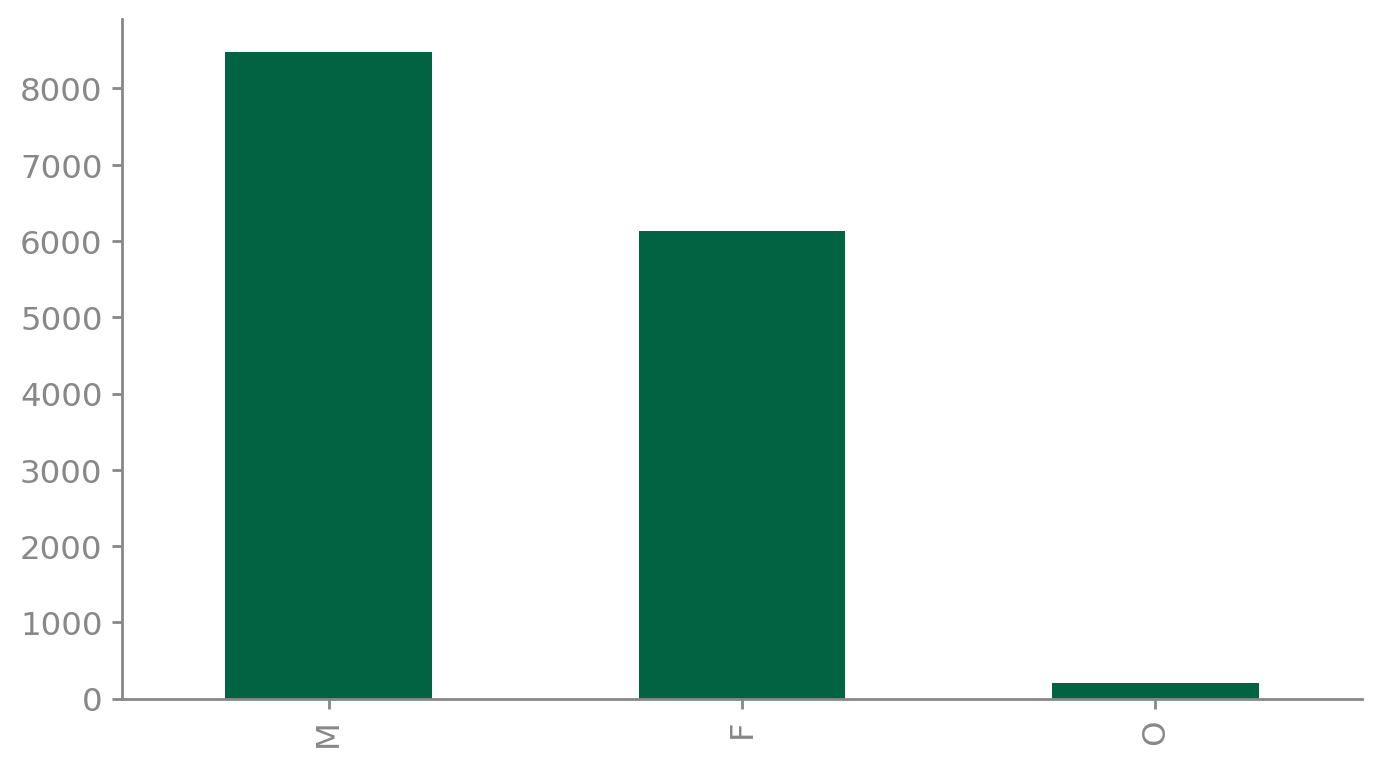

In [22]:
profile["gender"].value_counts().plot.bar();

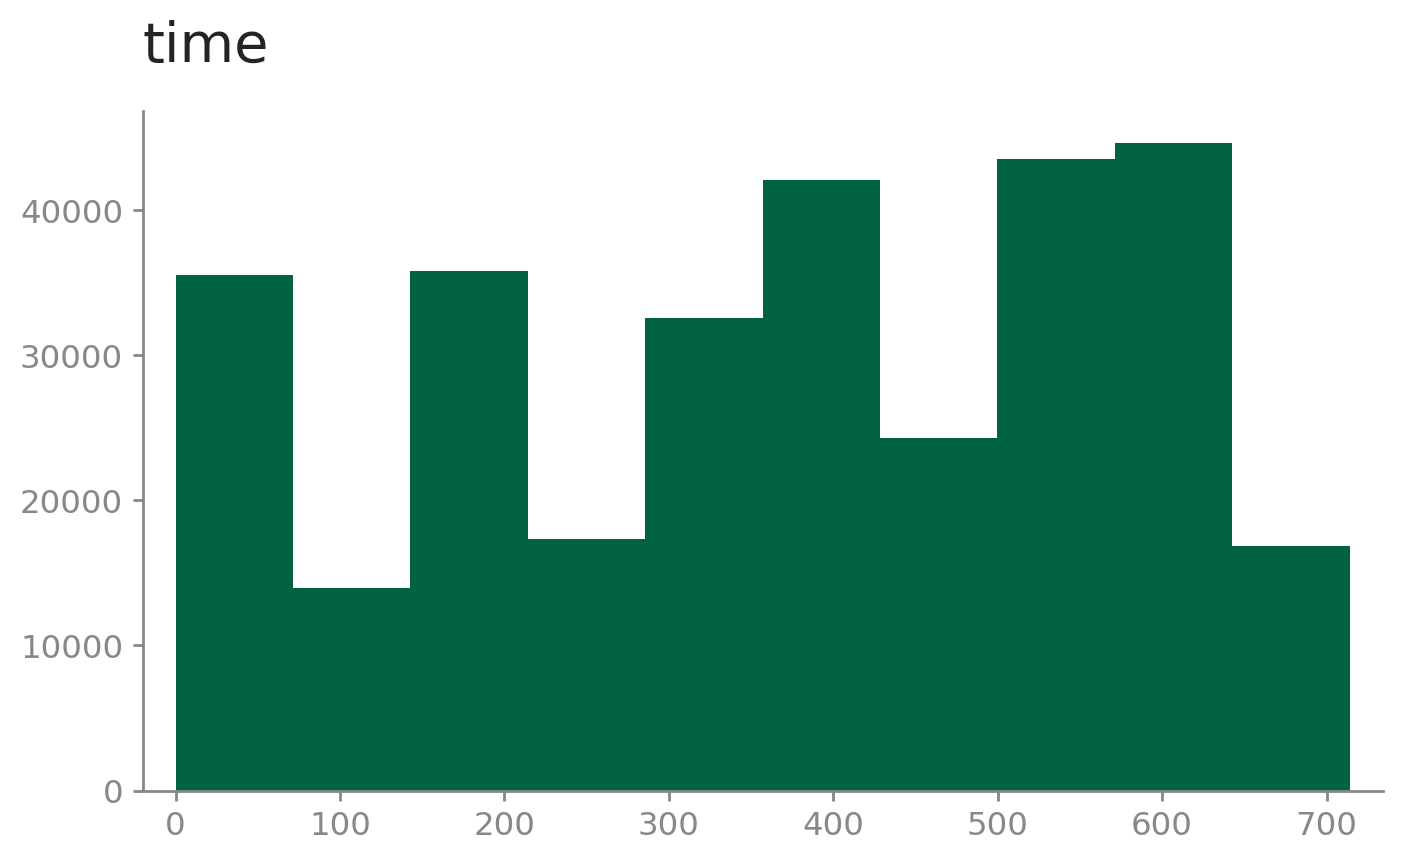

In [23]:
transcript.hist();

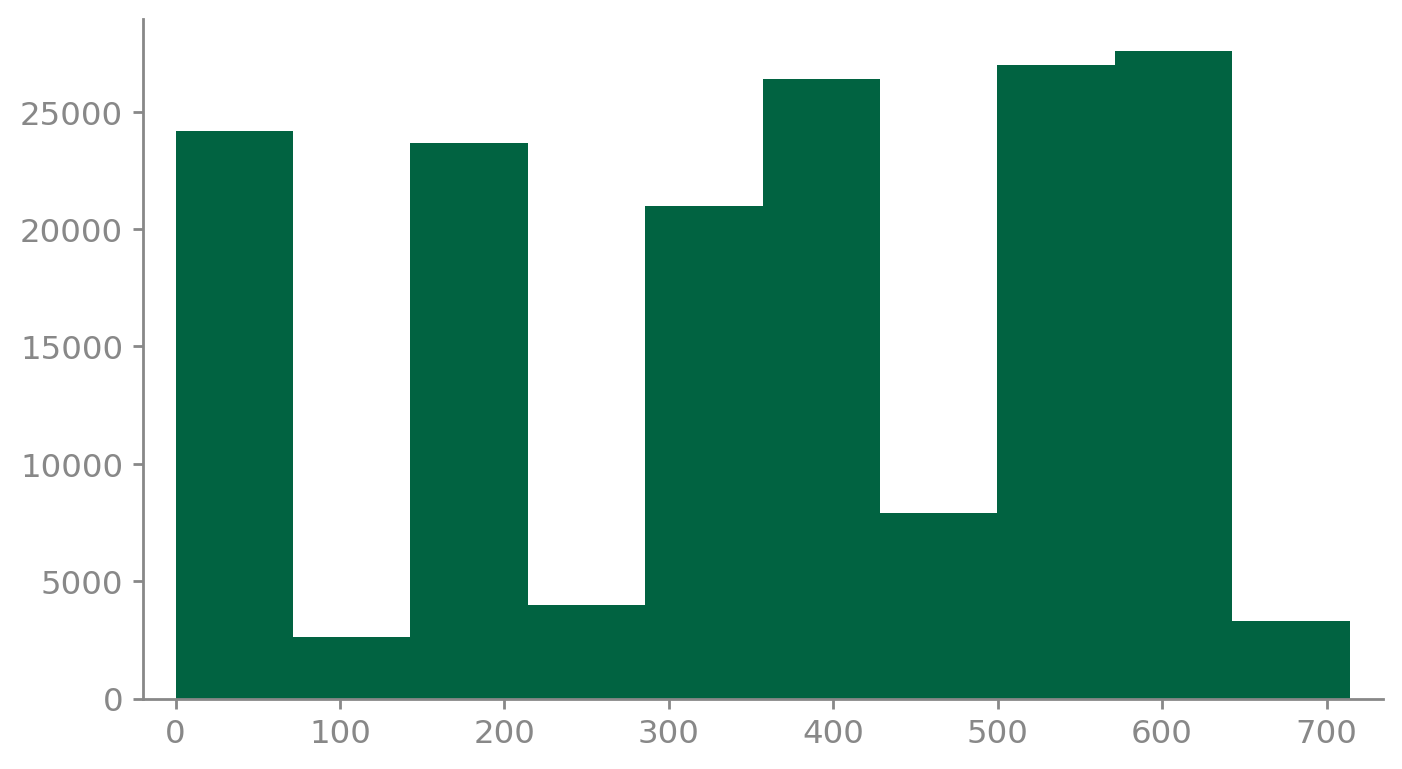

In [24]:
offer["time"].hist();

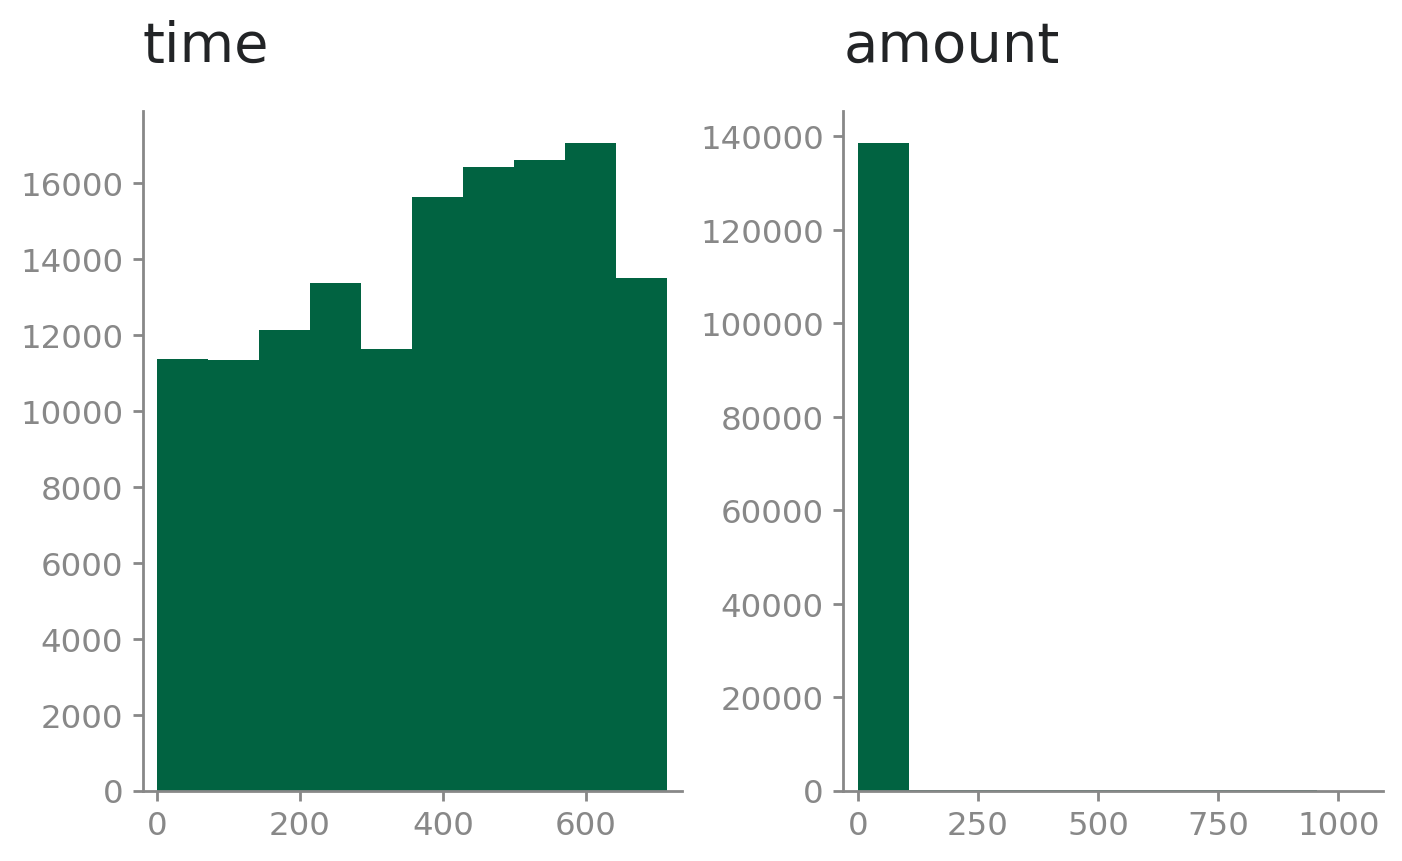

In [25]:
transaction.hist();

In [26]:
profile.describe()

,age,income,year,month
count,17000.000000,14825.000000,17000.000000,17000.000000
mean,62.531412,65404.991568,2016.635000,6.683529
std,26.738580,21598.299410,1.177624,3.487098
min,18.000000,30000.000000,2013.000000,1.000000
25%,45.000000,49000.000000,2016.000000,4.000000
50%,58.000000,64000.000000,2017.000000,7.000000
75%,73.000000,80000.000000,2017.000000,10.000000
max,118.000000,120000.000000,2018.000000,12.000000


In [202]:
transcript = pd.merge(transcript, profile, how="left", left_on="person", right_on="id")
transcript = pd.merge(transcript, portfolio, how="left", left_on="offer_id", right_on="id")
transcript.drop(columns=["value", "id_x", "id_y"], inplace=True)
transcript.head()

,person,event,time,offer_id,amount,gender,age,became_member_on,income,year,month,cohort,reward,channels,difficulty,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0,2017,5,2017-05,5.0,"[web, email, mobile]",5.0,7.0,bogo
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,None,118,2017-08-04,NaN,2017,8,2017-08,5.0,"[web, email]",20.0,10.0,discount
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,M,68,2018-04-26,70000.0,2018,4,2018-04,2.0,"[web, email, mobile]",10.0,7.0,discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,None,118,2017-09-25,NaN,2017,9,2017-09,2.0,"[web, email, mobile, social]",10.0,10.0,discount
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,None,118,2017-10-02,NaN,2017,10,2017-10,10.0,"[web, email, mobile, social]",10.0,5.0,bogo


In [203]:
transcript.shape

(306534, 17)

In [204]:
df_validity = transcript[transcript["event"] == "offer received"][["time", "duration"]]
df_validity["duration"] = df_validity["duration"].astype(int) * 24 + df_validity["time"]
df_validity["validity"] = df_validity[["time", "duration"]].values.tolist()
df_validity

,time,duration,validity
0,0,168,"[0, 168]"
1,0,240,"[0, 240]"
2,0,168,"[0, 168]"
3,0,240,"[0, 240]"
4,0,120,"[0, 120]"
...,...,...,...
257882,576,744,"[576, 744]"
257883,576,744,"[576, 744]"
257884,576,744,"[576, 744]"
257885,576,744,"[576, 744]"


In [205]:
transcript = pd.merge(transcript, df_validity["validity"], how="left", left_index=True, right_index=True)
transcript

,person,event,time,offer_id,amount,gender,age,became_member_on,income,year,month,cohort,reward,channels,difficulty,duration,offer_type,validity
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0,2017,5,2017-05,5.0,"[web, email, mobile]",5.0,7.0,bogo,"[0, 168]"
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,None,118,2017-08-04,NaN,2017,8,2017-08,5.0,"[web, email]",20.0,10.0,discount,"[0, 240]"
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,M,68,2018-04-26,70000.0,2018,4,2018-04,2.0,"[web, email, mobile]",10.0,7.0,discount,"[0, 168]"
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,None,118,2017-09-25,NaN,2017,9,2017-09,2.0,"[web, email, mobile, social]",10.0,10.0,discount,"[0, 240]"
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,None,118,2017-10-02,NaN,2017,10,2017-10,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,"[0, 120]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,None,1.59,M,66,2018-01-01,47000.0,2018,1,2018-01,NaN,NaN,NaN,NaN,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,None,9.53,M,52,2018-04-08,62000.0,2018,4,2018-04,NaN,NaN,NaN,NaN,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,None,3.61,F,63,2013-09-22,52000.0,2013,9,2013-09,NaN,NaN,NaN,NaN,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,None,3.53,M,57,2016-07-09,40000.0,2016,7,2016-07,NaN,NaN,NaN,NaN,NaN,NaN


In [209]:
df_persons = pd.DataFrame(transcript["person"].unique(), columns=["person_id"])
df_persons

,person_id
0,78afa995795e4d85b5d9ceeca43f5fef
1,a03223e636434f42ac4c3df47e8bac43
2,e2127556f4f64592b11af22de27a7932
3,8ec6ce2a7e7949b1bf142def7d0e0586
4,68617ca6246f4fbc85e91a2a49552598
...,...
16995,9fcbff4f8d7241faa4ab8a9d19c8a812
16996,ebae5093b436466c9fbd097cb7434023
16997,912b9f623b9e4b4eb99b6dc919f09a93
16998,3045af4e98794a04a5542d3eac939b1f


In [197]:
log = df_enriched.copy()
column = "validity"

In [ ]:
log[log[column] == event][["person", "time"]]
    .groupby(["person"])
    .agg({"time": lambda x: list(x)})
    .reset_index()
persons = pd.merge(persons, event_times, how="left", left_on="person_id", right_on="person")
persons.drop(columns="person", inplace=True)
persons.rename(columns={"time": event}, inplace=True)

In [207]:
events = ["offer received", "offer viewed", "transaction", "offer completed"]

In [211]:
def get_event_times(persons, log, column, events):
    for event in events:
        event_times = (
            log[log[column] == event][["person", "time"]]
                .groupby(["person"])
                .agg({"time": lambda x: list(x)})
                .reset_index()
        )
        persons = pd.merge(persons, event_times, how="left", left_on="person_id", right_on="person")
        persons.drop(columns="person", inplace=True)
        persons.rename(columns={"time": event}, inplace=True)
        if event == "offer received":
            validity = (
                log[log[column] == event][["person", "validity"]]
                    .groupby(["person"])
                    .agg({"validity": lambda x: list(x)})
                    .reset_index()
            )
            persons = pd.merge(persons, validity, how="left", left_on="person_id", right_on="person")
            persons.drop(columns="person", inplace=True)
            persons.rename(columns={"time": event}, inplace=True)
    return persons

In [213]:
df_persons = get_event_times(df_persons, transcript, column="event", events=events)
df_persons

,person_id,offer received,validity,offer viewed,transaction,offer completed
0,78afa995795e4d85b5d9ceeca43f5fef,"[0, 168, 408, 504]","[[0, 168], [168, 240], [408, 576], [504, 624]]","[6, 216, 408, 582]","[132, 144, 222, 240, 378, 510, 534]","[132, 510, 510]"
1,a03223e636434f42ac4c3df47e8bac43,"[0, 336, 408, 504, 576]","[[0, 240], [336, 432], [408, 480], [504, 744],...","[6, 336, 624]","[234, 264, 612]",NaN
2,e2127556f4f64592b11af22de27a7932,"[0, 336, 408, 504]","[[0, 168], [336, 432], [408, 576], [504, 744]]","[18, 420, 522]","[288, 294, 522]","[522, 522]"
3,8ec6ce2a7e7949b1bf142def7d0e0586,"[0, 168, 336, 408, 504]","[[0, 240], [168, 288], [336, 432], [408, 576],...","[12, 216, 366, 462, 522]",NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,"[0, 168, 336, 408, 504]","[[0, 120], [168, 336], [336, 504], [408, 576],...","[84, 348, 432, 648]","[354, 654]",NaN
...,...,...,...,...,...,...
16995,9fcbff4f8d7241faa4ab8a9d19c8a812,"[504, 576]","[[504, 600], [576, 696]]","[504, 576]",NaN,NaN
16996,ebae5093b436466c9fbd097cb7434023,[576],"[[576, 816]]",[588],"[516, 660]",[660]
16997,912b9f623b9e4b4eb99b6dc919f09a93,[576],"[[576, 696]]",[594],NaN,NaN
16998,3045af4e98794a04a5542d3eac939b1f,[576],"[[576, 696]]",[576],NaN,NaN


In [80]:
(
    df_enriched[df_enriched["event"] == "offer received"][
        ["person", "time"]
    ]
    .groupby(["person"])
    .agg({"time": lambda x: list(x)})
    .reset_index()
)

,person,time
0,0009655768c64bdeb2e877511632db8f,"[168, 336, 408, 504, 576]"
1,00116118485d4dfda04fdbaba9a87b5c,"[168, 576]"
2,0011e0d4e6b944f998e987f904e8c1e5,"[0, 168, 336, 408, 504]"
3,0020c2b971eb4e9188eac86d93036a77,"[0, 168, 336, 408, 504]"
4,0020ccbbb6d84e358d3414a3ff76cffd,"[168, 336, 408, 504]"
...,...,...
16989,fff3ba4757bd42088c044ca26d73817a,"[0, 168, 336, 408, 504, 576]"
16990,fff7576017104bcc8677a8d63322b5e1,"[0, 168, 408, 504, 576]"
16991,fff8957ea8b240a6b5e634b6ee8eafcf,"[408, 504, 576]"
16992,fffad4f4828548d1b5583907f2e9906b,"[0, 168, 408, 576]"


## 3. Data preparation

## 4. Modelling

## 5. Evaluation

## 6. Deployment